In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
df_train = pd.read_csv(r"C:\Users\Habiba Elkashef\Documents\PythonProjects\ML_models\Dataset\train.csv")
df_test  = pd.read_csv(r"C:\Users\Habiba Elkashef\Documents\PythonProjects\ML_models\Dataset\test.csv")

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)

Train shape: (345056, 54)
Test shape : (86264, 54)


In [17]:
# Replace inf values and drop NaNs
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [18]:
X_train = df_train.drop(columns=['label', 'label_encoded'], errors='ignore')
y_train = df_train['label_encoded']

X_test = df_test.drop(columns=['label', 'label_encoded'], errors='ignore')
y_test = df_test['label_encoded']

y_train_labels = df_train["label"]
y_test_labels  = df_test["label"]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (345056, 52)
X_test : (86264, 52)


In [19]:
label_mapping = (
    df_train[["label_encoded", "label"]]
    .drop_duplicates()
    .sort_values("label_encoded")
    .set_index("label_encoded")["label"]
    .to_dict()
)

print(label_mapping)

{0: 'Benign', 1: 'DNS', 2: 'LDAP', 3: 'MSSQL', 4: 'NTP', 5: 'NetBIOS', 6: 'Portmap', 7: 'SNMP', 8: 'Syn', 9: 'TFTP', 10: 'UDP', 11: 'UDPLag'}


In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [21]:
TIMESTEPS = 1

X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, X_train.shape[1])
X_test  = X_test.reshape(X_test.shape[0],  TIMESTEPS, X_test.shape[1])

print("Reshaped X_train:", X_train.shape)
print("Reshaped X_test :", X_test.shape)

Reshaped X_train: (345056, 1, 52)
Reshaped X_test : (86264, 1, 52)


In [22]:
num_classes = y_train.nunique()

def build_cnn_lstm_model():
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),

        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),

        Conv1D(filters=128, kernel_size=1, activation='relu'),
        BatchNormalization(),

        LSTM(128),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model

In [23]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.36740135011392916), np.int64(1): np.float64(9.797160704145371), np.int64(2): np.float64(10.741377163491471), np.int64(3): np.float64(2.439316819364325), np.int64(4): np.float64(0.2961528690409981), np.int64(5): np.float64(28.92823608316566), np.int64(6): np.float64(52.4720194647202), np.int64(7): np.float64(13.226617601962587), np.int64(8): np.float64(0.7280031056424798), np.int64(9): np.float64(0.36336677871290046), np.int64(10): np.float64(1.2607272302116217), np.int64(11): np.float64(4.026700275404939)}


In [24]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [ ]:
BEST_MODEL_PATH = "best_cnn_lstm_fold_model.h5"

best_f1 = -1.0
best_fold = None

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
cv_accuracies = []
cv_f1_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    print(f"\n========== Fold {fold} ==========")

    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = build_cnn_lstm_model()

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    

    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
        class_weight=class_weight_dict,
        verbose=1
    )

    # ---- Evaluate ----
    y_val_probs = model.predict(X_val)
    y_val_pred = np.argmax(y_val_probs, axis=1)

    acc = np.mean(y_val_pred == y_val.values)
    f1  = f1_score(y_val, y_val_pred, average='weighted')

    cv_accuracies.append(acc)
    cv_f1_scores.append(f1)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} F1-score: {f1:.4f}")

    # ---- Save BEST model ----
    if f1 > best_f1:
        best_f1 = f1
        best_fold = fold
        model.save(BEST_MODEL_PATH)
        print(f"Best model updated (Fold {fold})")

    fold += 1

print("\n==============================")
print("Accuracy per fold:", cv_accuracies)
print("F1-score per fold:", cv_f1_scores)
print(f"Best model saved from Fold {best_fold} with F1 = {best_f1:.4f}")


========== Fold 1 ==========
Epoch 1/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.9067 - loss: 0.8792 - val_accuracy: 0.9352 - val_loss: 0.2147
Epoch 2/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9357 - loss: 0.7425 - val_accuracy: 0.9453 - val_loss: 0.1850
Epoch 3/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.9442 - loss: 0.7037 - val_accuracy: 0.9609 - val_loss: 0.1532
Epoch 4/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9503 - loss: 0.6816 - val_accuracy: 0.9516 - val_loss: 0.1728
Epoch 5/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9519 - loss: 0.6778 - val_accuracy: 0.9505 - val_loss: 0.1751
Epoch 6/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9548 - loss: 0.6687 - val_accuracy: 0.9640 - val_loss: 0.1337
Epoch 7/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9548 - loss: 0.6673 - val_accuracy: 0.9510 - val_loss: 0.1594
Epoch 8/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/st

Fold 1 Accuracy: 0.9640
Fold 1 F1-score: 0.9641
Best model updated (Fold 1)

========== Fold 2 ==========
Epoch 1/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.9098 - loss: 0.8680 - val_accuracy: 0.9508 - val_loss: 0.1888
Epoch 2/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9320 - loss: 0.7434 - val_accuracy: 0.9451 - val_loss: 0.1857
Epoch 3/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9418 - loss: 0.7058 - val_accuracy: 0.9494 - val_loss: 0.1900
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Fold 2 Accuracy: 0.9508
Fold 2 F1-score: 0.9495

========== Fold 3 ==========
Epoch 1/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9136 - loss: 0.8698 - val_accuracy: 0.9402 - val_loss: 0.2001
Epoch 2/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9348 - loss: 0.7545 - val_accuracy: 0.9022 - val_loss: 0.3228
Epoch 3/10
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9423 - loss: 0.7126 - val_accuracy: 0.9504 - val_

2696/2696 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

      Benign     0.9926    0.9916    0.9921     19566
         DNS     0.1495    0.0654    0.0910       734
        LDAP     0.4459    0.6712    0.5358       669
       MSSQL     0.8647    0.8894    0.8769      2947
         NTP     0.9971    0.9940    0.9956     24274
     NetBIOS     0.7500    0.0121    0.0238       248
     Portmap     0.1977    0.8613    0.3215       137
        SNMP     0.4234    0.6059    0.4985       543
         Syn     0.9976    0.9845    0.9910      9875
        TFTP     0.9998    0.9920    0.9959     19783
         UDP     0.9134    0.9528    0.9327      5702
      UDPLag     0.9028    0.7385    0.8124      1786

    accuracy                         0.9644     86264
   macro avg     0.7196    0.7299    0.6723     86264
weighted avg     0.9677    0.9644    0.9641     86264



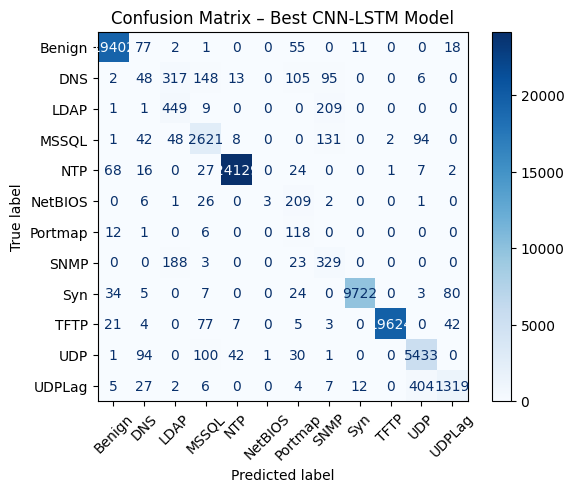

In [26]:
# Load best model
best_model = load_model(BEST_MODEL_PATH)

# Predict on test set (X_test MUST be 3D)
y_test_probs = best_model.predict(X_test)
y_test_pred_encoded = np.argmax(y_test_probs, axis=1)

# Convert encoded → original labels
y_test_pred_labels = pd.Series(y_test_pred_encoded).map(label_mapping)

# ===============================
# Classification Report (ORIGINAL labels)
# ===============================
print(
    classification_report(
        y_test_labels,
        y_test_pred_labels,
        digits=4
    )
)

# ===============================
# Confusion Matrix (ORIGINAL labels)
# ===============================
class_names = list(label_mapping.values())

cm = confusion_matrix(
    y_test_labels,
    y_test_pred_labels,
    labels=class_names
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    values_format="d"
)

plt.title("Confusion Matrix – Best CNN-LSTM Model")
plt.show()

In [27]:
def predict_and_save_cnn_lstm(
    df,
    model_path,
    label_mapping,
    output_csv,
    label_col="label",
    label_encoded_col="label_encoded",
    timesteps=1
):
    """
    Predict using a saved CNN-LSTM model, print TEST report,
    and save results to CSV (using original labels).
    """

    # Load CNN-LSTM model
    model = load_model(model_path)

    # Copy dataframe
    df_out = df.copy()

    # Prepare features (TEST data)
    X = df.drop(columns=[label_col, label_encoded_col]).values

    # Reshape for CNN-LSTM (3D input)
    X = X.reshape(X.shape[0], timesteps, X.shape[1])

    # True labels (original)
    y_true_labels = df[label_col].values

    # Predict probabilities
    y_pred_probs = model.predict(X, verbose=0)

    # Encoded predictions
    y_pred_encoded = np.argmax(y_pred_probs, axis=1)

    # Decode predictions → original labels
    y_pred_labels = (
        pd.Series(y_pred_encoded)
        .map(label_mapping)
        .values
    )

    # Add columns to dataframe
    df_out["true_label"] = y_true_labels
    df_out["predicted_label"] = y_pred_labels

    # =========================
    # TESTING CLASSIFICATION REPORT
    # =========================
    print("\nCNN-LSTM – TEST Classification Report (df_test)")
    print(
        classification_report(
            y_true_labels,
            y_pred_labels,
            digits=4
        )
    )

    # Explicit testing accuracy (optional)
    test_accuracy = accuracy_score(y_true_labels, y_pred_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # =========================
    # Save CSV
    # =========================
    df_out.to_csv(output_csv, index=False)
    print(f"\nPredictions saved to: {output_csv}")

    return df_out


In [28]:
df_test_predictions = predict_and_save_cnn_lstm(
    df=df_test,
    model_path="best_cnn_lstm_fold_model.h5",
    label_mapping=label_mapping,
    output_csv="cnn_lstm_test_predictions.csv",
    timesteps=1
)


CNN-LSTM – TEST Classification Report (df_test)


c:\Users\Habiba Elkashef\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Habiba Elkashef\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Habiba Elkashef\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

              precision    recall  f1-score   support

      Benign     0.2258    0.4998    0.3110     19566
         DNS     0.0154    0.0163    0.0159       734
        LDAP     0.0168    0.9761    0.0330       669
       MSSQL     0.0000    0.0000    0.0000      2947
         NTP     0.0228    0.0020    0.0036     24274
     NetBIOS     0.0000    0.0000    0.0000       248
     Portmap     0.0000    0.0000    0.0000       137
        SNMP     0.0000    0.0000    0.0000       543
         Syn     0.0000    0.0000    0.0000      9875
        TFTP     0.0000    0.0000    0.0000     19783
         UDP     0.0000    0.0000    0.0000      5702
      UDPLag     0.0000    0.0000    0.0000      1786

    accuracy                         0.1216     86264
   macro avg     0.0234    0.1245    0.0303     86264
weighted avg     0.0579    0.1216    0.0720     86264

Test Accuracy: 0.1216

Predictions saved to: cnn_lstm_test_predictions.csv
